In [1]:
%matplotlib inline

import numpy as np
from scipy import integrate

from nolitsa import dimension

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation

Manual implementation

**Lorenz system**

Model the chaotic time series as solutions of dynamic Lorenz equation with parameters:  
$ \sigma = 10, \ \beta = 8/3 $  for both cases  
and $r = 26 \ (partly \ chaotic) $ for the first case and $r = 28 \ (fully \ chaotic) $ for second case

\begin{cases} 
              \dot x = \sigma (y - x) \\ 
              \dot y = rx - y - xz \\      
              \dot z = xy - bz
\end{cases}


**Runge-Kutta method 4rth order:**

For the equation $ \dot x = F(x,t) $, we compute slope elements and the average them with weights:

$$ k_{1} = F(t,x) \\
   k_{2} = F(t + \frac {\delta t} {2}, x + \frac {\delta t *k_{1}} {2}) \\
   k_{3} = F(t + \frac {\delta t} {2}, x + \frac {\delta t *k_{2}} {2}) \\
   k_{2} = F(t +  {\delta t}, x + {\delta t *k_{3}})
$$
$$ \\ $$
$$
\\ 
\delta x = \frac {\delta t (k_{1} + 2k_{2} + 2k_{3} + k_{4})} {6} \\
x(t + \delta t) = x(t) + \delta x
$$


-----
# MY RUNGE-KUTTA

In [2]:
def deriviation_step(initial_state, derivative, dt):
    """
    Compute one evaluation step
    """
    
    # evaluation of state
    state = {}
    
    if not derivative:
        state["x"] = initial_state["x"] 
        state["y"] = initial_state["y"] 
        state["z"] = initial_state["z"] 
    else:
        state["x"] = initial_state["x"] + derivative["dx"] * dt
        state["y"] = initial_state["y"] + derivative["dy"] * dt
        state["z"] = initial_state["z"] + derivative["dz"] * dt
        
    # evaluation of derivative
    derivative_next_step = {}
    
    derivative_next_step["dx"] = sigma * (state["y"] - state["x"])
    derivative_next_step["dy"] = rho * state["x"] - state["y"] - state["x"] * state["z"]
    derivative_next_step["dz"] = state["x"] * state["y"] - beta * state["z"]
    
    return derivative_next_step
    
def RK_integration(state, dt):
    """
    Runge-Kutta integration of the 4th order at a time `t` with a state `state` 
    with the step `dt`
    """
    
    # Prepare 1,2,3,4 - order derivatives for the final "best" derivative,
    # gained as 4 first elements of the Taylor's approximation
    
    # Random initialization of defivatives(probably will have to moove)
    derivative = dict({"dx": np.random.normal(),
                       "dy": np.random.normal(),
                       "dz": np.random.normal()})
    rk1 = deriviation_step(initial_state=state,
                           derivative=None,
                           dt=dt*0)
    
    rk2 = deriviation_step(initial_state=state, 
                           derivative=rk1,
                           dt=dt*0.5
                           )
    
    rk3 = deriviation_step(initial_state=state, 
                           derivative=rk2,
                           dt=dt*0.5)
    
    rk4 = deriviation_step(initial_state=state,
                           derivative=rk3,
                           dt=dt)
    
    # When all derivatives are ready, it's time to construct Rung-Kutta derivative
    # !!!! DOUBLE CHECK THE TAYLOR'S APPROXIMATIONS !!!!
    dxdt = (1 / 6) * (rk1["dx"] + 2* rk2["dx"] + 2 * rk3["dx"] + rk4["dx"])
    dydt = (1 / 6) * (rk1["dy"] + 2* rk2["dy"] + 2 * rk3["dy"] + rk4["dy"])
    dzdt = (1 / 6) * (rk1["dz"] + 2* rk2["dz"] + 2 * rk3["dz"] + rk4["dz"])
    
    state["x"] = state["x"] + dxdt * dt
    state["y"] = state["y"] + dydt * dt
    state["z"] = state["z"] + dzdt * dt
    return state

## Generation of time series

In [7]:
beta = 8 / 3
rho = 28
sigma = 10

initial_state = dict({"x": 0.62225717 ,
                   "y": -0.08232857 ,
                   "z": 30.60845379})

ode_solutions = []
for iteration in range(0, int(1e6)):
    state_t = RK_integration(initial_state, dt=0.005)
    ode_solutions.append(list(state_t.values()))
result = np.array(ode_solutions)

$\rho = 26$

In [4]:
series_26 = result[:, 0]

$\rho = 28$

In [8]:
series_28 = result[:, 0]

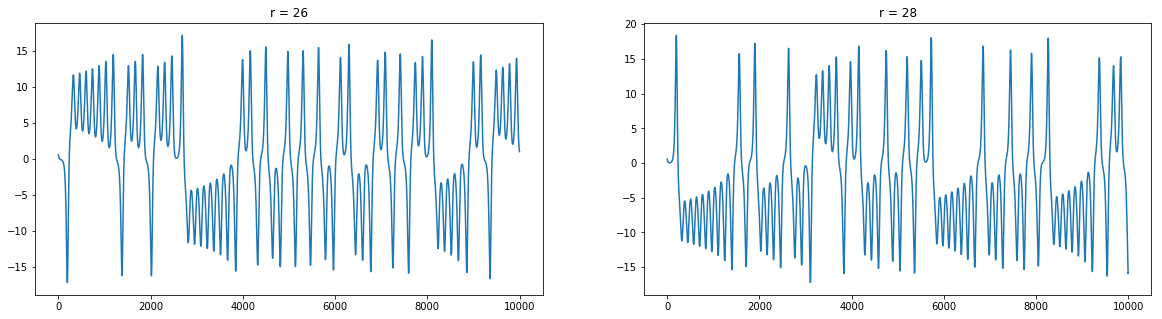

In [79]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(20,5);
ax1.plot(series_26[:10000]);
ax1.set_title("r = 26");
ax2.plot(series_28[:10000]);
ax2.set_title("r = 28");

-----
## Estimating the dimensionality


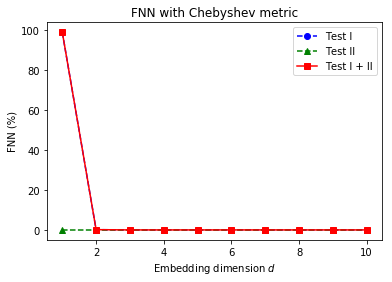

In [91]:
# Generate data.
# x = np.random.normal(size=5000)
dim = np.arange(1, 10 + 1)

plt.figure(1)
f1, f2, f3 = dimension.fnn(series_28[:100000], tau=1, dim=dim, window=10, metric='euclidean')
plt.title(r'FNN with Chebyshev metric')
plt.xlabel(r'Embedding dimension $d$')
plt.ylabel(r'FNN (%)')
plt.plot(dim, 100 * f1, 'bo--', label=r'Test I')
plt.plot(dim, 100 * f2, 'g^--', label=r'Test II')
plt.plot(dim, 100 * f3, 'rs-', label=r'Test I + II')
plt.legend()

# plt.figure(2)
# f1, f2, f3 = dimension.fnn(x, tau=1, dim=dim, window=0, metric='euclidean')
# plt.title(r'FNN with Euclidean metric')
# plt.xlabel(r'Embedding dimension $d$')
# plt.ylabel(r'FNN (%)')
# plt.plot(dim, 100 * f1, 'bo--', label=r'Test I')
# plt.plot(dim, 100 * f2, 'g^--', label=r'Test II')
# plt.plot(dim, 100 * f3, 'rs-', label=r'Test I + II')
# plt.legend()

# plt.figure(3)
# f1, f2, f3 = dimension.fnn(x, tau=1, dim=dim, window=0, metric='cityblock')
# plt.title(r'FNN with cityblock (Manhattan) metric')
# plt.xlabel(r'Embedding dimension $d$')
# plt.ylabel(r'FNN (%)')
# plt.plot(dim, 100 * f1, 'bo--', label=r'Test I')
# plt.plot(dim, 100 * f2, 'g^--', label=r'Test II')
# plt.plot(dim, 100 * f3, 'rs-', label=r'Test I + II')
# plt.legend()

# plt.show()

-----
## Lyapunov characteristics

**Algorithm:**  
##### 1. Recontruction of $x$ time series to $\{X_{1}, ..., X_{M}\}$ Where $X_{i}$ is the vector of the form $\{x_{j}, ..., x_{j+m}\};$ Where $m$ is the embedding length. Also, elements of the time series are not followed by each other - they are sampled with some gap inteeval betwee them.  
##### 2. When ts is reconstructed, nearest neighbors for each $X_{i}$ with respected distances are calculated. Though, there is one constrain: Not to measure distances between distances from the same trajectory(cause this will make divergency very small, which will badly affect lyapunov values), nearest neighbors are considered only if there's a sufficient time distance between them. 
##### 3. Last step is straight-forward(but i don't understand the sum boundaries:  

$$ \lambda_{1} = \sum_{all \ points} {log(||point_{i} - neighbor(point_{i})||)} $$ 

-> $ \epsilon= \delta  e^{\lambda t} $

\- But how shall we estimate the dimension?...   
\- With help of FNN of course!
\- We have no time for FNN  
*MAD IDEA:* What if we look at these madly-oscillating parts and say, that we choose the size of dimension equal to number of time stamps it takes to oscilate once! The core idea is simple: we don't want to find closest points from th

In [10]:
from nolitsa import lyapunov
lyapunov_26 = lyapunov.mle_embed(series_26[:100000], dim=[5], tau=13, maxt=300, window=60)[0]
lyapunov_28 = lyapunov.mle_embed(series_28[:100000], dim=[5], tau=13, maxt=300, window=60)[0]

In [213]:
x, dim=[1], tau=1, window=10, maxt=500,
              metric='euclidean', maxnum=None, parallel=True):

-1.711725320830755

###### 2. Construct an array with indencies to the nearest neighboors and distances to them

In [190]:
l = len(series_26)
indencies = np.zeros(l)
distances = np.zeros(l)
for point_index, point_value in enumerate(series_26[:10]):
    valid = [False]
    number_of_neighboors = 2
    while not np.count_nonzero(valid):
        nearest_distances, nearest_indexes = tree.query(x=[point_value], 
                                                        k=number_of_neighboors)
        valid = (nearest_distances > 0) & (np.abs(nearest_indexes - point_index) >= 1)
        number_of_neighboors = number_of_neighboors + 1
    distances[point_index] = nearest_distances[valid][0]
    indencies[point_index] = nearest_indexes[valid][0]

In [192]:
distances

array([5.08776290e-07, 2.16777898e-06, 3.57954239e-06, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [137]:
valid = [False]
while not np.count_nonzero(valid):
    v = np.random.normal(1)
    v = v < 0
    valid.append(v)

## Forming z-vectors

In [96]:
from itertools import combinations
templates = combinations(range(1,10), 3)

In [97]:
a = list(templates)

**Estimating the MLE**  
Before estimating the MLE, we need to estimate the optinal number of points to consider in MLE estimations  
(Missing part)
We are going to estimate the MLE on-the-spot

In [15]:
from nolitsa import data, lyapunov
d = lyapunov.mle_embed(x, dim=4, tau=tau, maxt=300, window=window)[0]


In [20]:
len(series_28[1:45:1]

44

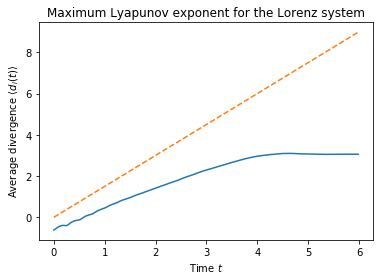

In [54]:
from nolitsa import data, lyapunov
import numpy as np
import matplotlib.pyplot as plt

sample = 0.02
x0 = [0.62225717, -0.08232857, 30.60845379]
x = data.lorenz(length=5000, sample=sample, x0=x0,
                sigma=10.0, beta=8 / 3, rho=28)[1][:, 0]

# Choose appropriate Theiler window.
window = 60

# Time delay.
tau = 13

# Embedding dimension.
dim = [5]

d = lyapunov.mle_embed(x, dim=dim, tau=tau, maxt=300, window=window)[0]
t = np.arange(300)

plt.title('Maximum Lyapunov exponent for the Lorenz system')
plt.xlabel(r'Time $t$')
plt.ylabel(r'Average divergence $\langle d_i(t) \rangle$')
plt.plot(sample * t, d)
plt.plot(sample * t, sample * t * 1.50, '--')

plt.show()

## Wishart algorithm

The goal is to cluster *z-vectors*

The defenetion of significant cluster $\Omega^{l}$ is: $max\{|p(x_{i}) - p(x_{j})|, \forall i,j\in\Omega^{l} \}$ where $p(x_{i})=\frac {k}{NV_{k}(x)}$

- Magicly choose the *k* parameter
- For each point find *k* nearest neighbors and calculate distance for k-th nearest neighbor (the sphere radius)
- After constructing the list of format 

     $$\{x_{1}:[neighbor^{1}_{1},... , neighbor^{1}_{k}, ]\}$$
     $$\{x_{2}:[neighbor^{2}_{1},... , neighbor^{2}_{k}, ]\}$$
     $$ ... $$
     $$\{x_{N}:[neighbor^{N}_{1},... , neighbor^{N}_{k}, ]\}$$
The list must be sorted by the distance to the k-th nearest neigbor. Formally, we name this list a graph $G(Z_{n}, U_{n})$, where $Z_{n}$ are all verticies $x_{i}$ and $U_{n}=\{(i,j):d(x_{i}, x_{j}) \leq d_{k}(x_{i}), i \neq j\} $

- After that we launch a cycle on the sorted list of vertices and at each step execute these:
  - Form a new graph $G(Z_{i}, U_{i})$, where $Z_{i} = \{x_{i}, i=\overline{1,...i}\}$ and $U_{i}$ is the sub-entity of $U_{n}$ vergies of which are connected to $Z_{i}$  
  - Then, we apply one of the these rules:
    - case $x_{i}$ is isolated: create a new cluster out of it and move on to the next point
    - case $x_{i}$ is only connected to cluster $l$ then:
      - case $l$ is completed, then assign $x_{i}$ to zero cluster
      - case $l$ is not completed, then assign $x_{i}$ to it
    - case $x_{i}$ is connected to several clusters $l_{1},..., l_{t}$
      - case all clusters are completed, then assign $x_{i}$ to zero cluster
      - case number of significant clusters $z(h) \leq t$
        - case $z(h) > 1$ or $l_{1}=0$, then assign  $x_{i}$ to zero cluster, mark significent clusters as completed, and delete all not significant classes
        - case $z(h) \leq 1$ and $l_{1} > 0$, then merge $l_{2},..., l_{t}$ into $l_{1}$
       

In [ ]:
class Wilshart()



##### Parameters
The dimension of the *z-vectors* is chosen to be 4 and the lag time varying from 1 to 10 between each pair of point in the reconstruction window, so the reconstruction window is 31 point

In [34]:
series_26 = np.array(series_26.tolist())
reconstructed_shape = (int(1e6) // 31, 31)
t = series_26[:reconstructed_shape[0]*reconstructed_shape[1]]
t = t.reshape(reconstructed_shape)

(31,)

In [12]:
1e6

1000000.0

In [31]:
tree = KDTree(data=series_26.reshape(-1, 1))
n = len(series_26)
dists = np.empty(n)
indices = np.empty(n, dtype=int)

In [41]:
window = 1
maxnum = (window + 1) + 1 + (window + 1)
p_norm = 2

In [68]:
ii = np.squeeze(indices)

In [82]:
for i, x in enumerate(series_26[:100]):
    print(i, x)
    for k in range(2, maxnum + 2):
        print("NEEEEEEEEWWW K", k)
        dist, index = tree.query([x], k=k, p=p)
        valid = (np.abs(index - i) > window) & (dist > 0)
        print("Distances:", dist, "Indexes:", index, "Valid", valid)
        
        if np.count_nonzero(valid):
            print("FUUCK")
            dists[i] = dist[valid][0]
            indices[i] = index[valid][0]
            print("HOORAY", dist[valid][0], index[valid][0])
            break

array([960423, 104941,   7471, 687303, 478681, 373232, 287125, 714392,
       322314, 783498])